# 01. Quickstart

This is tested on Python 3.6 on Ubuntu 18.04, using tensorflow 1.15.

### (Optional) Reduce Logging

TF and HOOMD-TF print a lot of information. We'll turn it down the make the output of cells a little easier to read.

In [1]:
# (Optional) This block is to surpress the warning on loading tensorflow package
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
# import the hoomd, htf packages
import hoomd
import hoomd.htf as htf
import tensorflow as tf

## Build the computational graph

Here we prepare the computations that will be executed at each step during the simulation. We have access to placeholders for the neighbor list, positions, types, box dimensions of the simulation. Here we define a simple 1 / r potential, save its energy, and use the auto-differentiation tool to compute forces. 

In [3]:
########### Graph Building Code ###########
graph = htf.SimModel(8, output_forces=True) # max neighbors = 8
pair_energy = graph.nlist_rinv # nlist_rinv is neighbor 1 / r
particle_energy = tf.reduce_sum(pair_energy, axis=1) # sum over neighbors
forces = graph.compute_forces(particle_energy) # compute forces
graph.save_tensor(particle_energy, name='energy')
graph.save('my_model', forces)

## Running the simulation

Now we run the simulation using the usual hoomd-blue syntax. Notice that we load our model, whch was written to a file in the above cell. We can specify things like how often the model is called, how often it is saved, etc. in the `attach` command. This simulation is 144 particles in 2D, whose forces are the ones we defined above. 

In [4]:
########### Hoomd-Sim Code ################
hoomd.context.initialize("--mode=cpu")
# this will start TensorFlow, so it goes
# in a with statement for clean exit.
#
# if calling initialize() without params, 
# it will be throw error of using unexpected parameter 'f'
# ref: https://github.com/glotzerlab/hoomd-blue/blob/master/hoomd/context.py#L204
with htf.tfcompute('my_model') as tfcompute:
    # create a square lattice
    rcut = 5
    system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.0),
                                        n=[12,12])
    nlist = hoomd.md.nlist.cell()
    hoomd.md.integrate.mode_standard(dt=0.005)
    hoomd.md.integrate.nve(group=hoomd.group.all())
    tfcompute.attach(nlist, r_cut=rcut, save_period=10)
    hoomd.run(100)

HOOMD-blue v2.5.1 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 03/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 144 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
notice(2): TF Session Manager has released control. Starting HOO

## Analysis

Now we'll load our variable, which was saved every 10 steps, and plot it.

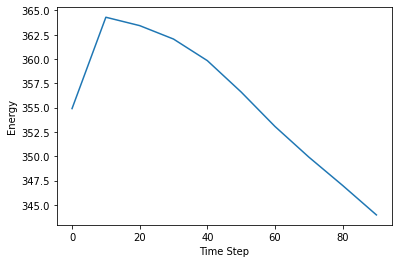

In [5]:
import matplotlib.pyplot as plt
import numpy as np 

sys_energy = []
# we saved every 10 steps
for i in range(0, 100, 10):
    variables = htf.load_variables('my_model', ['energy'], i)
    # sum energy across particles
    sys_energy.append(np.sum(variables['energy']))
plt.plot(range(0,100, 10), sys_energy)
plt.ylabel('Energy')
plt.xlabel('Time Step')
plt.show()